In [62]:
# check if pyspark works
import pyspark
print(pyspark.__version__)

3.5.1


In [63]:
from pyspark.sql import SparkSession

# Start spark session
spark = SparkSession.builder \
    .appName("Multiclass classification IoT") \
    .getOrCreate()

# Load datasets
def load_test_data(debug=False):
    if debug:
        test_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-test.csv", header=True, inferSchema=True).limit(200)
        train_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-train.csv", header=True, inferSchema=True).limit(300000)
    else:
        test_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-test.csv", header=True, inferSchema=True)
        train_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-train.csv", header=True, inferSchema=True)
        
    return test_data, train_data

test_data, train_data = load_test_data(debug=False)


In [64]:
# Display the first few rows of the training dataset to verify it's loaded correctly
train_data.show(5)
print(train_data.count())

# Display the first few rows of the testing dataset to verify it's loaded correctly
test_data.show(5)
print(test_data.count())

+-------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+--------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|IN_PKTS|OUT_BYTES|OUT_PKTS|TCP_FLAGS|CLIENT_TCP_FLAGS|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|DURATION_OUT|MIN_TTL|MAX_TTL|LONGEST_FLOW_PKT|SHORTEST_FLOW_PKT|MI

In [65]:
# Print the schema of the loaded data to confirm the data types of each column
train_data.printSchema()
test_data.printSchema()

root
 |-- IPV4_SRC_ADDR: string (nullable = true)
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- IPV4_DST_ADDR: string (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- L7_PROTO: double (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- OUT_BYTES: integer (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- CLIENT_TCP_FLAGS: integer (nullable = true)
 |-- SERVER_TCP_FLAGS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- DURATION_IN: integer (nullable = true)
 |-- DURATION_OUT: integer (nullable = true)
 |-- MIN_TTL: integer (nullable = true)
 |-- MAX_TTL: integer (nullable = true)
 |-- LONGEST_FLOW_PKT: integer (nullable = true)
 |-- SHORTEST_FLOW_PKT: integer (nullable = true)
 |-- MIN_IP_PKT_LEN: integer (nullable = true)
 |-- MAX_IP_PKT_LEN: integer (nullable = true)
 |-- SRC_TO

### Data Preprocessing and Exploratory Data Analysis (EDA)

In [66]:
# Identifying missing values
from pyspark.sql.functions import col, count, when, isnan

# Count nulls and NaNs in each column
def count_missing(data):
    #data.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in data.columns]).show()
    data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

count_missing(train_data)
count_missing(test_data)

+-------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|IN_PKTS|OUT_BYTES|OUT_PKTS|TCP_FLAGS|CLIENT_TCP_FLAGS|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|DURATION_OUT|MIN_TTL|MAX_TTL|LONGEST_FLOW_PKT|SHORTEST_FLOW_PKT|MIN_

The dataset is clean and doesn't have any missing values, so there's no need for further cleaning.

#### Encoding
On the dataset, which consists of network traffic data, several categorical variables could potentially benefit from encoding. The decision to apply encoding techniques depends on whether the variables are nominal (without an inherent order) or ordinal (with a specific order) and whether they are used as features in the model. 

After an understanding of data and the variables meaning, we considered some variables for encoding:
- **IPV4_SRC_ADDR and IPV4_DST_ADDR** (Categorical nominal): These are IP addresses and typically should be treated as categorical.
- **Attack** (categorical Nominal): In machine learning projects involving classification tasks, the target variable (also known as the label or response variable) is crucial as it's the outcome the model is trying to predict. On the project, the target variable consists of categorical data (e.g., text labels representing different classes), it needs to be converted into a numeric format. This conversion is essential because most machine learning algorithms require numeric input to perform calculations during model training.


In [67]:
from pyspark.sql.functions import countDistinct

# Count distinct values in IPV4_SRC_ADDR
distinct_src_subnet_count = train_data.select(countDistinct("IPV4_SRC_ADDR").alias("Distinct_SRC_Count"))

# Count distinct values in IPV4_DST_ADDR
distinct_dst_subnet_count = train_data.select(countDistinct("IPV4_DST_ADDR").alias("Distinct_DST_Subnet"))

# Show the results
distinct_src_subnet_count.show(truncate=False)
distinct_dst_subnet_count.show(truncate=False)

+------------------+
|Distinct_SRC_Count|
+------------------+
|18538             |
+------------------+

+-------------------+
|Distinct_DST_Subnet|
+-------------------+
|6465               |
+-------------------+



Given the high number of distinct values in the IPV4_ADDR column, subnet segmentation was performed to facilitate more effective encoding. This approach reduces the granularity of the data, thereby simplifying the feature space without significantly compromising the informational value of the IP addresses. Segmentation enables us to manage the high cardinality of the IP addresses, which is critical for applying machine learning techniques efficiently and effectively. By categorizing the IP addresses into their respective subnets, we can capture essential network-level behaviors while avoiding the computational complexity associated with the vast number of unique full IP addresses.

In [68]:
from pyspark.sql.functions import concat_ws, split, col

def add_subnet_columns(data):
    # Add a new column for the subnet (first two octets) for source and destination IP addresses
    data = data.withColumn(
        "IPV4_SRC_ADDR_Subnet",
        concat_ws(".", split(col("IPV4_SRC_ADDR"), "\\.")[0], split(col("IPV4_SRC_ADDR"), "\\.")[1])
    )

    data = data.withColumn(
        "IPV4_DST_ADDR_Subnet",
        concat_ws(".", split(col("IPV4_DST_ADDR"), "\\.")[0], split(col("IPV4_DST_ADDR"), "\\.")[1])
    )

    return data

train_data = add_subnet_columns(train_data)
test_data = add_subnet_columns(test_data)

In [69]:
# Show the new columns along with the original IP addresses
train_data.select("IPV4_SRC_ADDR", "IPV4_SRC_ADDR_Subnet", "IPV4_DST_ADDR", "IPV4_DST_ADDR_Subnet").show(truncate=False)

+-------------+--------------------+--------------+--------------------+
|IPV4_SRC_ADDR|IPV4_SRC_ADDR_Subnet|IPV4_DST_ADDR |IPV4_DST_ADDR_Subnet|
+-------------+--------------------+--------------+--------------------+
|192.168.1.32 |192.168             |192.168.1.180 |192.168             |
|192.168.1.30 |192.168             |192.168.1.194 |192.168             |
|192.168.1.31 |192.168             |192.168.1.190 |192.168             |
|192.168.1.32 |192.168             |192.168.1.195 |192.168             |
|192.168.1.38 |192.168             |192.168.1.194 |192.168             |
|192.168.1.31 |192.168             |192.168.1.193 |192.168             |
|192.168.1.32 |192.168             |192.168.1.195 |192.168             |
|192.168.1.32 |192.168             |192.168.1.190 |192.168             |
|192.168.1.35 |192.168             |192.168.1.1   |192.168             |
|192.168.1.30 |192.168             |192.168.1.195 |192.168             |
|192.168.1.35 |192.168             |192.168.1.1   |

In [70]:
from pyspark.sql.functions import countDistinct

# Count distinct values in IPV4_SRC_ADDR_Subnet
distinct_src_subnet_count = train_data.select(countDistinct("IPV4_SRC_ADDR_Subnet").alias("Distinct_SRC_Subnet_Count"))

# Count distinct values in IPV4_DST_ADDR_Subnet
distinct_dst_subnet_count = train_data.select(countDistinct("IPV4_DST_ADDR_Subnet").alias("Distinct_DST_Subnet_Count"))

# Show the results
distinct_src_subnet_count.show(truncate=False)
distinct_dst_subnet_count.show(truncate=False)

+-------------------------+
|Distinct_SRC_Subnet_Count|
+-------------------------+
|15933                    |
+-------------------------+

+-------------------------+
|Distinct_DST_Subnet_Count|
+-------------------------+
|2832                     |
+-------------------------+



- **Source IP Dimensionality:** The modest reduction in unique source subnets compared to the full source IP count suggests that the network traffic originates from a diverse set of locations or devices, with slightly clustered but still quite spread out origins. This might imply that any predictive modeling using source subnets as a feature would still need to handle a relatively high number of categories, potentially requiring further techniques to manage dimensionality or enhance interpretability.

- **Destination IP Dimensionality:** The more significant reduction in unique destination subnets points to a higher level of concentration of network traffic towards certain destination networks or servers. For modeling purposes, this could mean that destination subnet could be a more impactful feature, providing stronger predictive signals with fewer categories, thus improving model performance and simplicity.

Given the results, for destination subnets, straightforward categorical encoding methods like one-hot encoding might be feasible given the reduced number of unique values. For source subnets, considering the still high number of unique categories, methods like feature hashing or embedding might be more appropriate to prevent models from becoming too complex.

In [71]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, FeatureHasher
from pyspark.ml import Pipeline

# Define Indexers and Encoders for categorical variables
attack_indexer = StringIndexer(inputCol="Attack", outputCol="attack_index")

# Destination address
dst_subnet_indexer = StringIndexer(inputCol="IPV4_DST_ADDR_Subnet", outputCol="dst_subnet_index")

# Source address
# Feature hashing for source subnet since lower cardinality
# Just for graphing
src_subnet_indexer = StringIndexer(inputCol="IPV4_SRC_ADDR_Subnet", outputCol="src_subnet_index")


# Create a pipeline for encoding
encoding_pipeline = Pipeline(stages=[
    attack_indexer, 
    dst_subnet_indexer, 
    src_subnet_indexer,
])

# Fit the encoding pipeline to the training data
encoding_model = encoding_pipeline.fit(train_data)

# Transform both training and test data
encoded_train_data = encoding_model.transform(train_data)
encoded_test_data = encoding_model.transform(test_data)



In [72]:
# Show encoded features to verify
encoded_train_data.select("Attack", "attack_index", "IPV4_SRC_ADDR_Subnet", "IPV4_DST_ADDR_Subnet", "dst_subnet_index", "src_subnet_index").limit(10).show(truncate=False)

+--------+------------+--------------------+--------------------+----------------+----------------+
|Attack  |attack_index|IPV4_SRC_ADDR_Subnet|IPV4_DST_ADDR_Subnet|dst_subnet_index|src_subnet_index|
+--------+------------+--------------------+--------------------+----------------+----------------+
|scanning|1.0         |192.168             |192.168             |0.0             |0.0             |
|scanning|1.0         |192.168             |192.168             |0.0             |0.0             |
|Benign  |0.0         |192.168             |192.168             |0.0             |0.0             |
|scanning|1.0         |192.168             |192.168             |0.0             |0.0             |
|ddos    |3.0         |192.168             |192.168             |0.0             |0.0             |
|Benign  |0.0         |192.168             |192.168             |0.0             |0.0             |
|Benign  |0.0         |192.168             |192.168             |0.0             |0.0             |


Drop transformed colums and keep only "dst_subnet_index" and "src_subnet_index"

In [73]:
# Drop the original columns that have been encoded and hashed
encoded_train_data = encoded_train_data.drop("Attack", "Label", "IPV4_SRC_ADDR_Subnet", "IPV4_DST_ADDR_Subnet", "IPV4_SRC_ADDR", "IPV4_DST_ADDR")
encoded_test_data = encoded_test_data.drop("Attack", "Label", "IPV4_SRC_ADDR_Subnet", "IPV4_DST_ADDR", "IPV4_SRC_ADDR", "IPV4_DST_ADDR")
# Show the final columns in the training data
encoded_train_data.printSchema()

root
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- L7_PROTO: double (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- OUT_BYTES: integer (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- CLIENT_TCP_FLAGS: integer (nullable = true)
 |-- SERVER_TCP_FLAGS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- DURATION_IN: integer (nullable = true)
 |-- DURATION_OUT: integer (nullable = true)
 |-- MIN_TTL: integer (nullable = true)
 |-- MAX_TTL: integer (nullable = true)
 |-- LONGEST_FLOW_PKT: integer (nullable = true)
 |-- SHORTEST_FLOW_PKT: integer (nullable = true)
 |-- MIN_IP_PKT_LEN: integer (nullable = true)
 |-- MAX_IP_PKT_LEN: integer (nullable = true)
 |-- SRC_TO_DST_SECOND_BYTES: double (nullable = true)
 |-- DST_TO_SRC_SECOND_BYTES: double (nullable

# EDA part
Converting dataset to pandas for graphics

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Row limit for converting to Pandas DataFrame for plotting (to avoid memory issues)
ROW_LIMIT = 200000

# Converte il DataFrame Spark in un DataFrame Pandas per l'analisi esplorativa
df_pd = encoded_train_data.limit(ROW_LIMIT).toPandas()


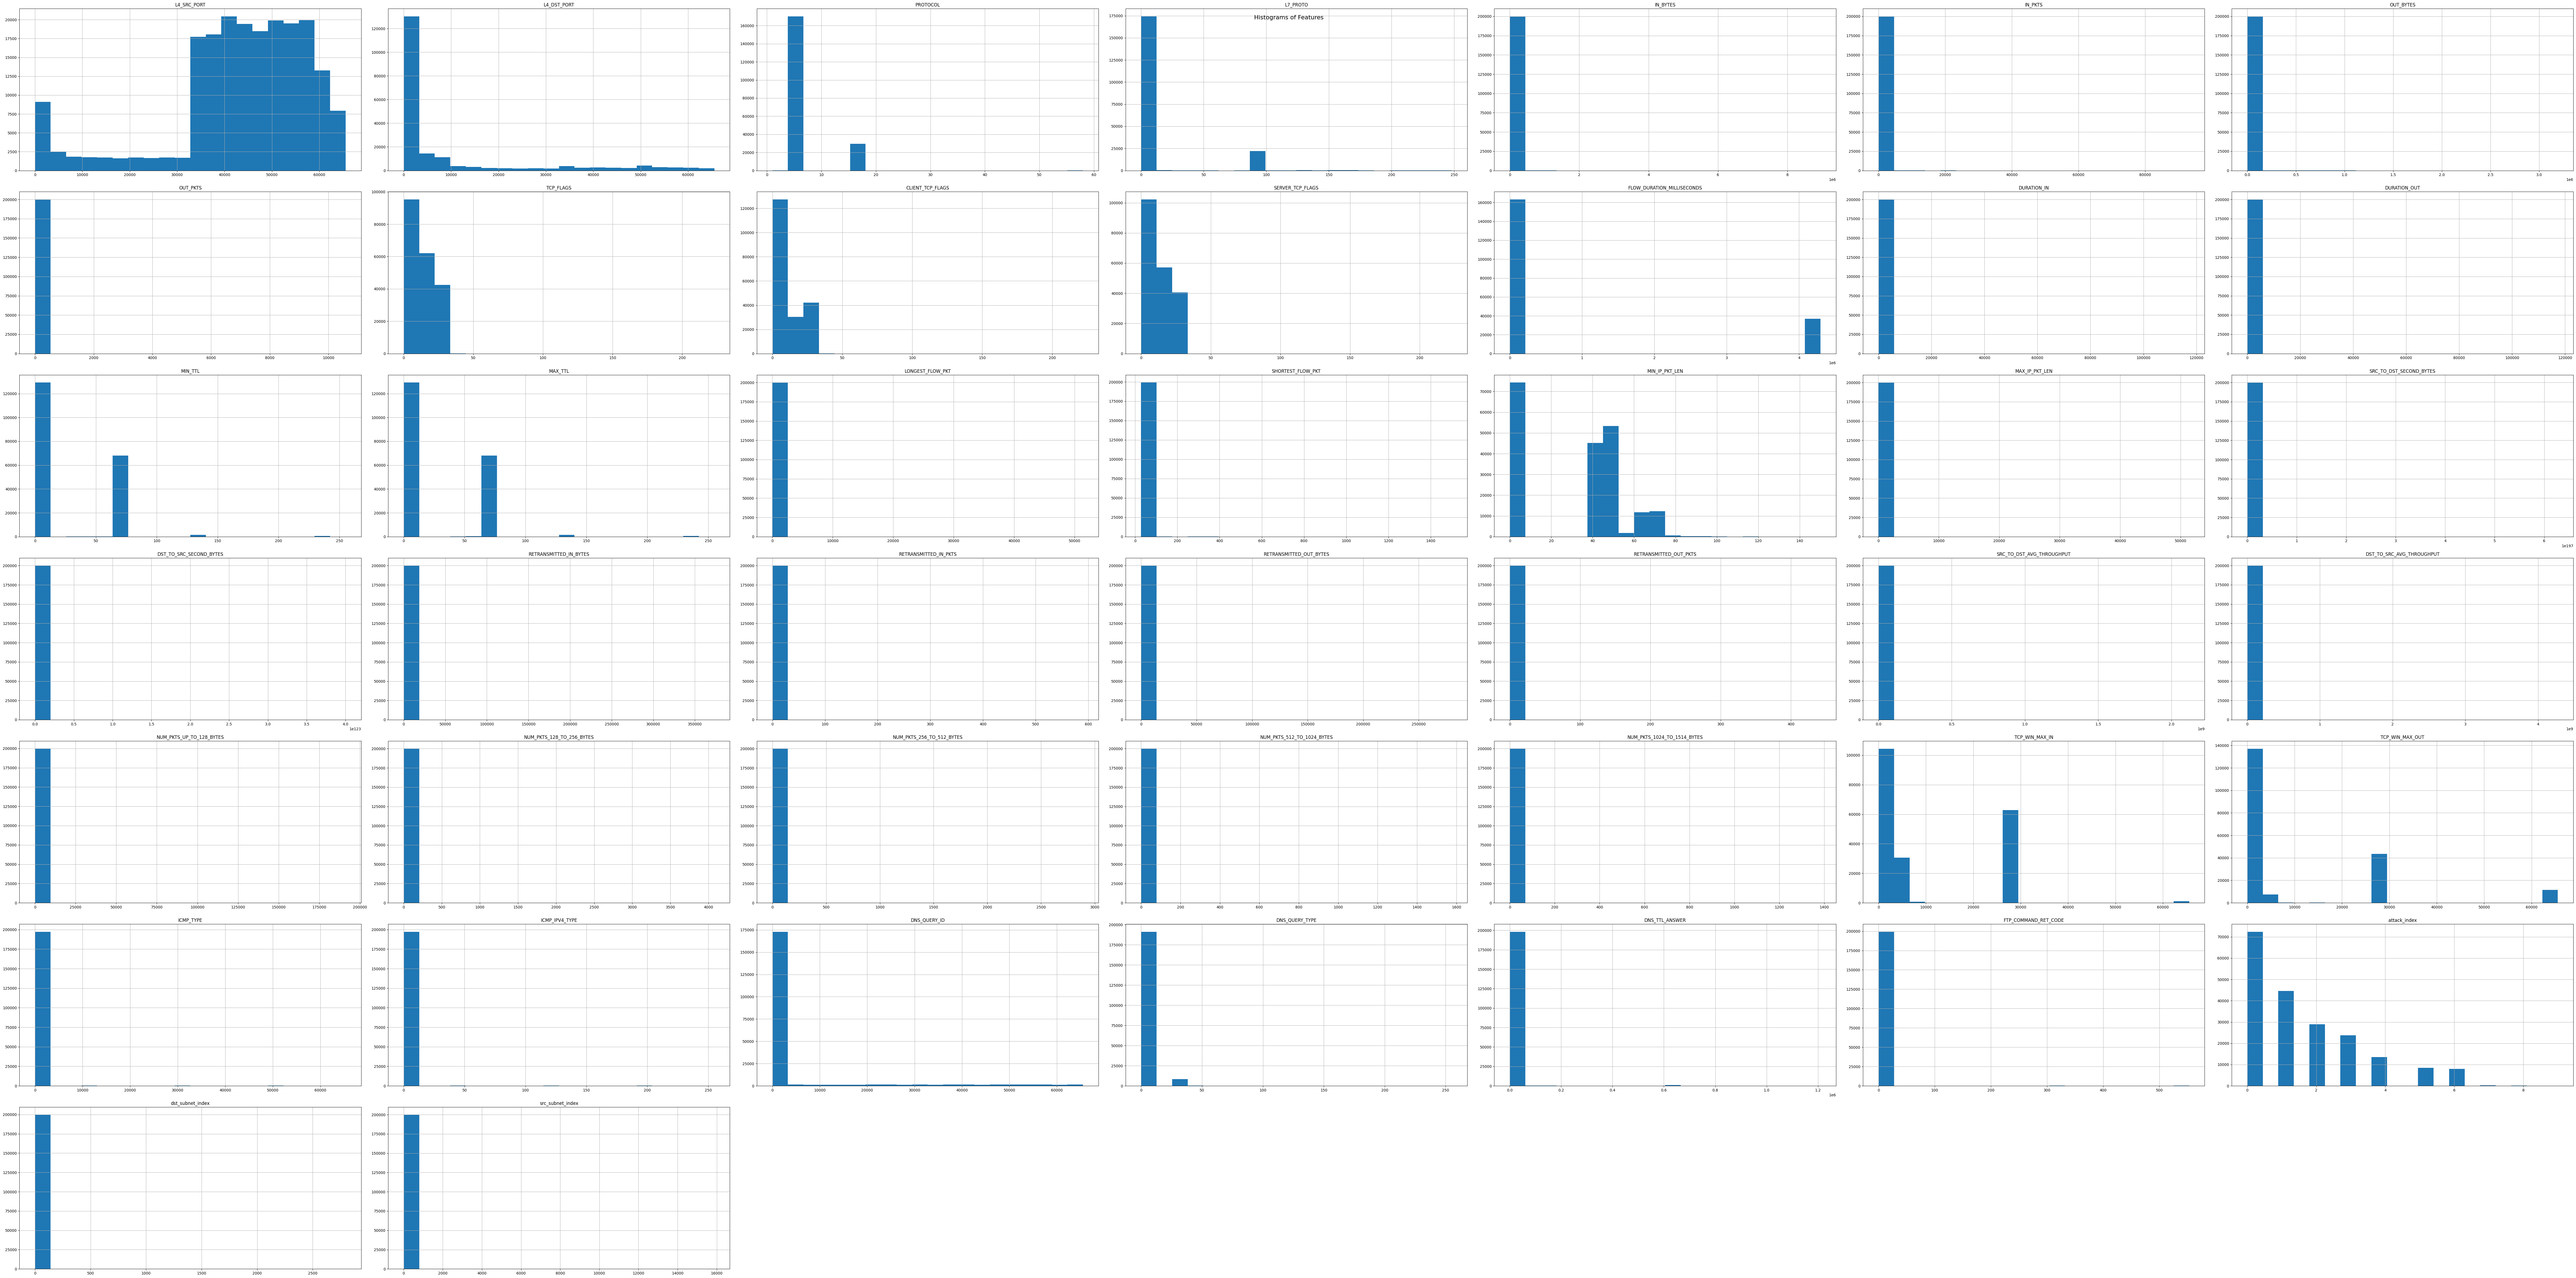

In [75]:
# Analisi esplorativa dei dati utilizzando Pandas e Seaborn
def features_hisogram(dataframe):
    # Istogrammi delle caratteristiche
    dataframe.hist(bins=20, figsize=(96, 48))
    plt.suptitle("Histograms of Features", fontsize=16)
    plt.tight_layout()
    plt.show()
    
features_hisogram(df_pd)

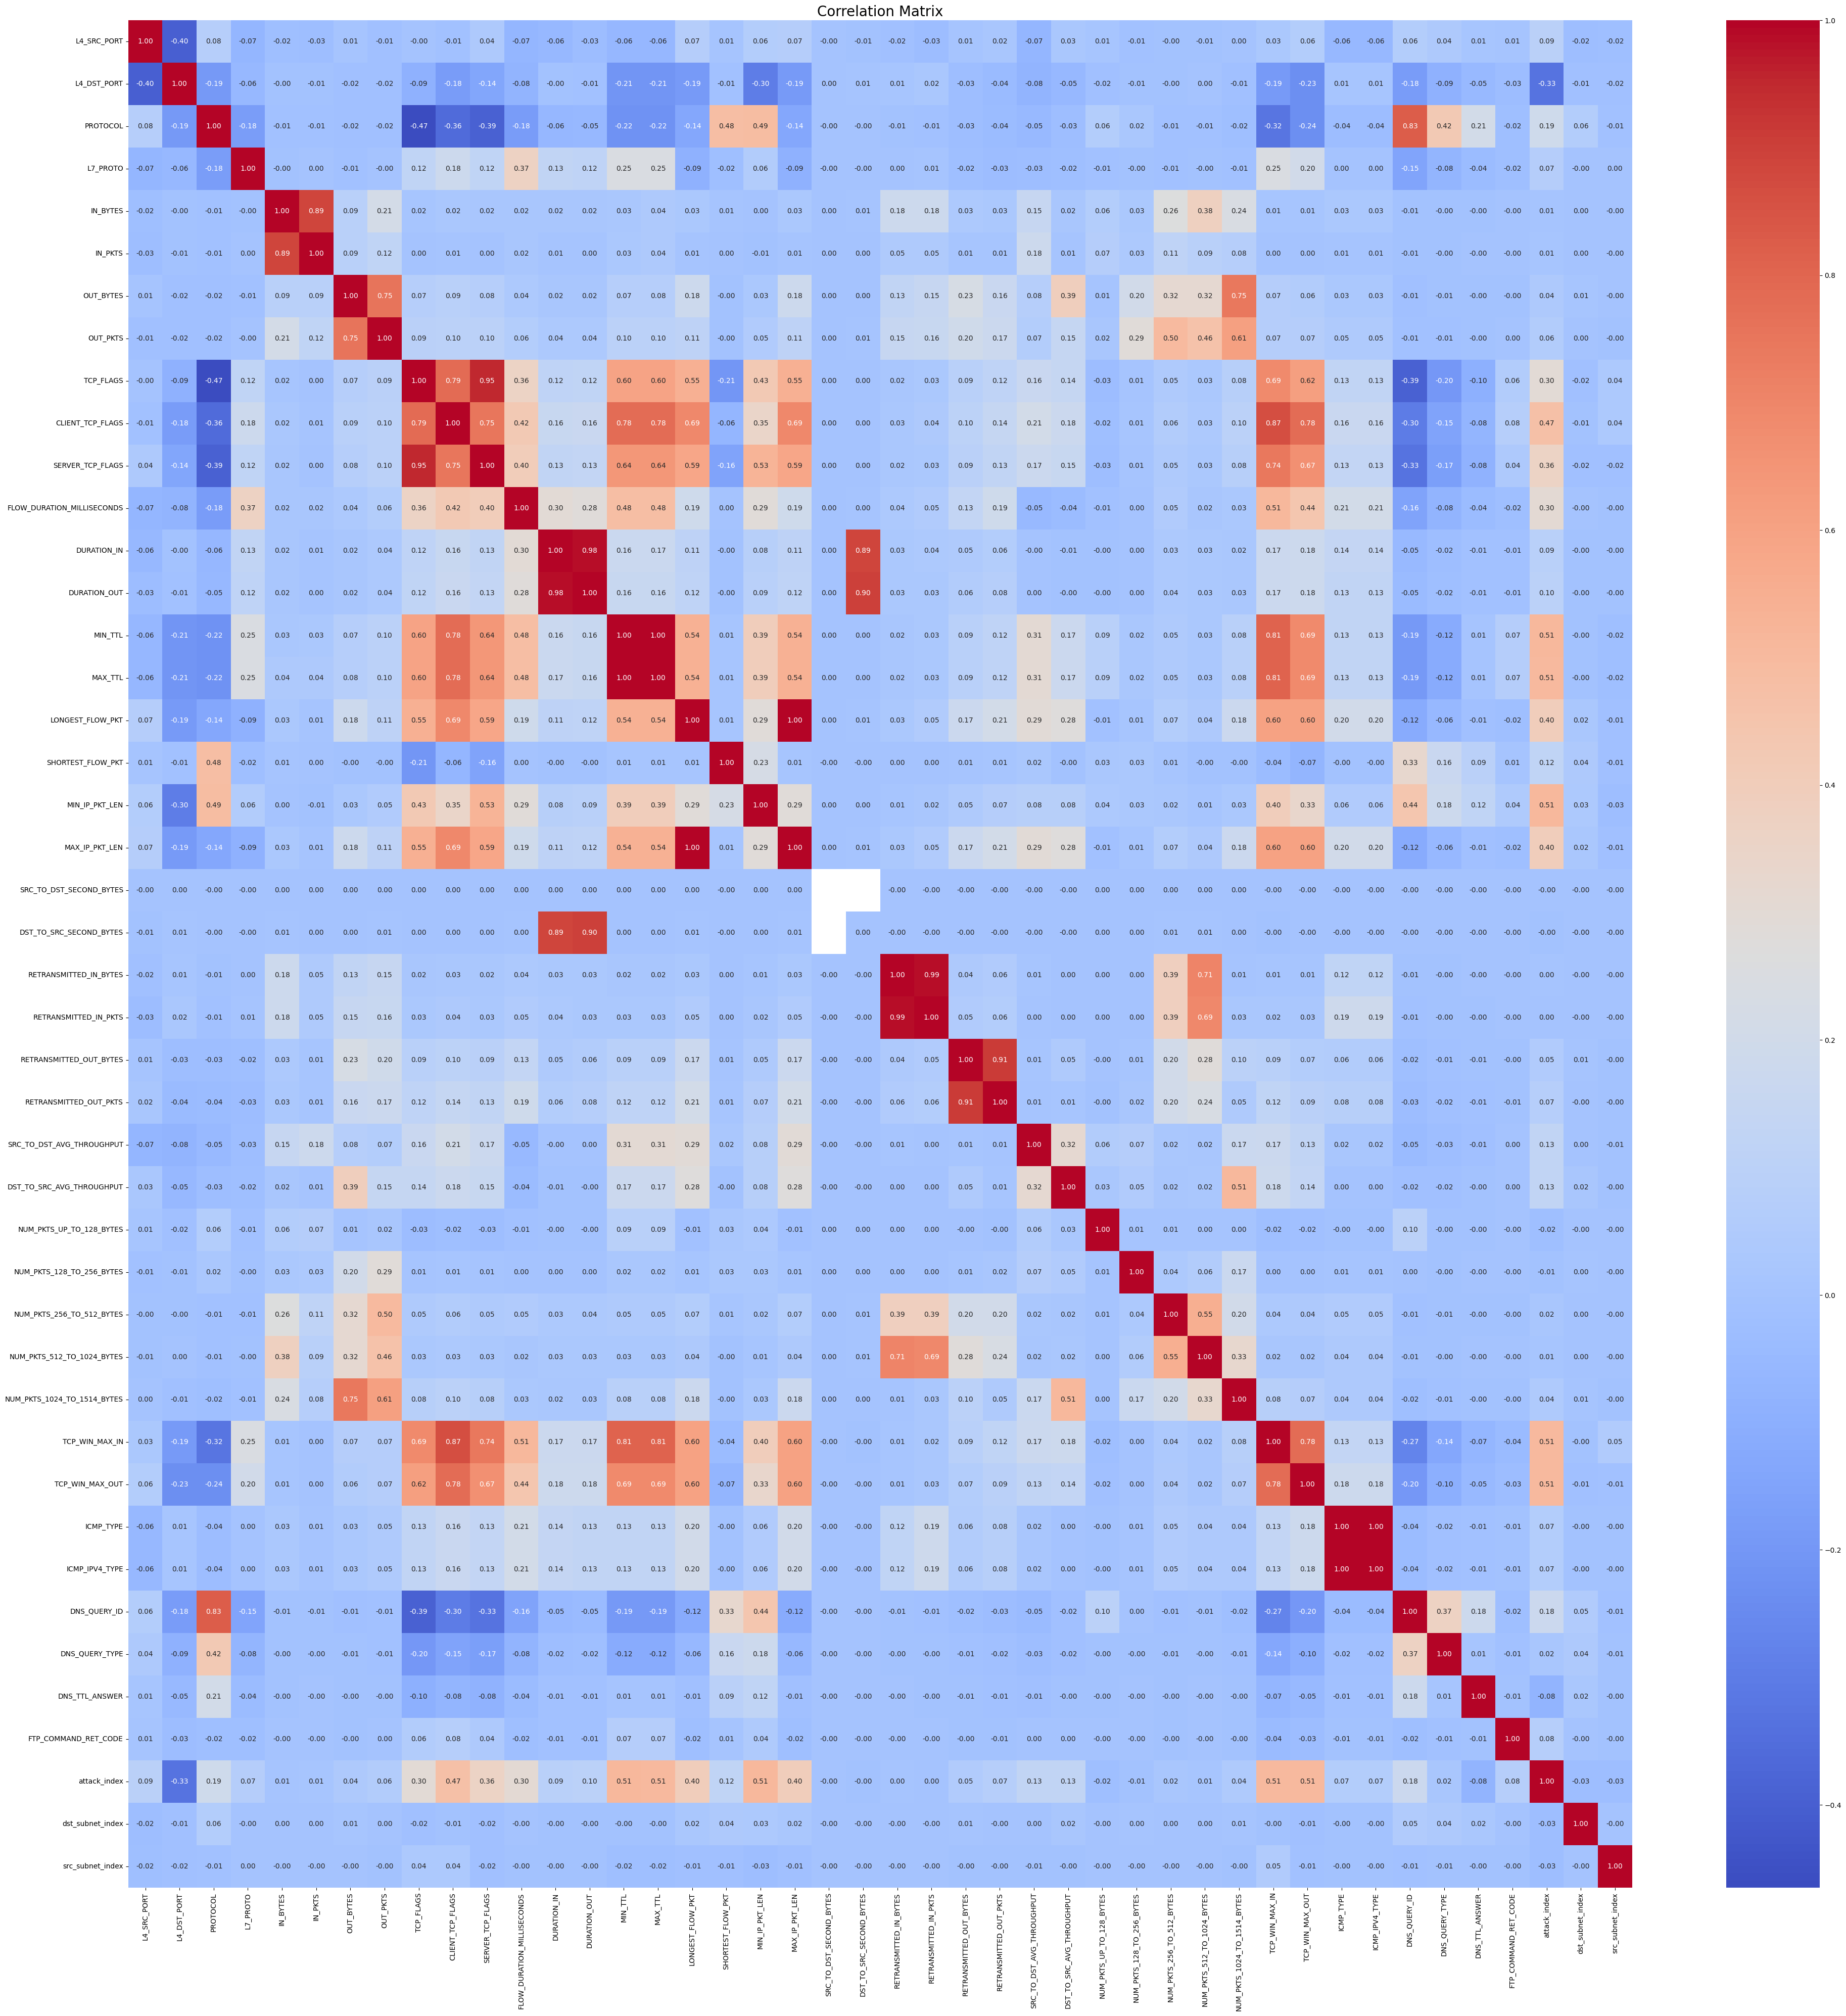

In [76]:
def heatmap(dataframe):
    # Matrice di correlazione
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(48, 48))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix', fontsize=20)
    plt.show()
    
heatmap(df_pd)

The PCA revealed that the first two principal components explain approximately 69.17% of the variance in the dataset, with significant contributions from features such as FLOW_DURATION_MILLISECONDS, TCP_WIN_MAX_OUT, and L4_DST_PORT. The heatmap provided a visual representation of feature correlations, identifying relationships that guided feature selection. The MI analysis highlighted MAX_IP_PKT_LEN and LONGEST_FLOW_PKT as the most informative features for predicting the target variable, attack_index, indicating their potential importance in the classification tasks.

In [77]:
# Multiple Information (MI) Analysis for the features
from sklearn.feature_selection import mutual_info_classif

# Select features and target
X = df_pd[df_pd.columns.difference(["attack_index"])]
y = df_pd["attack_index"]

# Calculate mutual information
mi = mutual_info_classif(X, y)

# Display Mutual Information scores
feature_mi_scores = [(feature, score) for feature, score in zip(X, mi)]
for feature, score in feature_mi_scores:
    print(f"Feature: {feature}, MI Score: {score}")

/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1746: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


Feature: CLIENT_TCP_FLAGS, MI Score: 0.7530765757539415
Feature: DNS_QUERY_ID, MI Score: 0.1765596836966674
Feature: DNS_QUERY_TYPE, MI Score: 0.19547457930189527
Feature: DNS_TTL_ANSWER, MI Score: 0.08068764894793112
Feature: DST_TO_SRC_AVG_THROUGHPUT, MI Score: 0.9220575712925143
Feature: DST_TO_SRC_SECOND_BYTES, MI Score: 0.0022191053401998673
Feature: DURATION_IN, MI Score: 0.20000754044262914
Feature: DURATION_OUT, MI Score: 0.22049036741022787
Feature: FLOW_DURATION_MILLISECONDS, MI Score: 0.20626331489210692
Feature: FTP_COMMAND_RET_CODE, MI Score: 0.008628452634199757
Feature: ICMP_IPV4_TYPE, MI Score: 0.02527693172771439
Feature: ICMP_TYPE, MI Score: 0.026890138725167656
Feature: IN_BYTES, MI Score: 1.220994238711065
Feature: IN_PKTS, MI Score: 0.4260887009086365
Feature: L4_DST_PORT, MI Score: 0.8933716033604591
Feature: L4_SRC_PORT, MI Score: 0.4911687207019564
Feature: L7_PROTO, MI Score: 0.3742427438024225
Feature: LONGEST_FLOW_PKT, MI Score: 1.151566600801365
Feature: MAX

In [78]:
# Frequencias de categoria
# This function calculates the frequency of each category in a given column
# It use the full dataset to calculate the frequencies

from pyspark.sql.functions import count

def category_frequencies(data, column):
    # Calcular a frequência das categorias na variável 'Attack'
    frequency = data.groupBy(column).agg(count("*").alias("frequency")).orderBy("frequency", ascending=False)
    #attack_freq.show(truncate=False)
    return frequency

category_frequencies(encoded_train_data, "attack_index").show(truncate=False)



+------------+---------+
|attack_index|frequency|
+------------+---------+
|0.0         |4880476  |
|1.0         |3024550  |
|2.0         |1963578  |
|3.0         |1621220  |
|4.0         |922329   |
|5.0         |570077   |
|6.0         |547856   |
|7.0         |13445    |
|8.0         |6128     |
|9.0         |2737     |
+------------+---------+



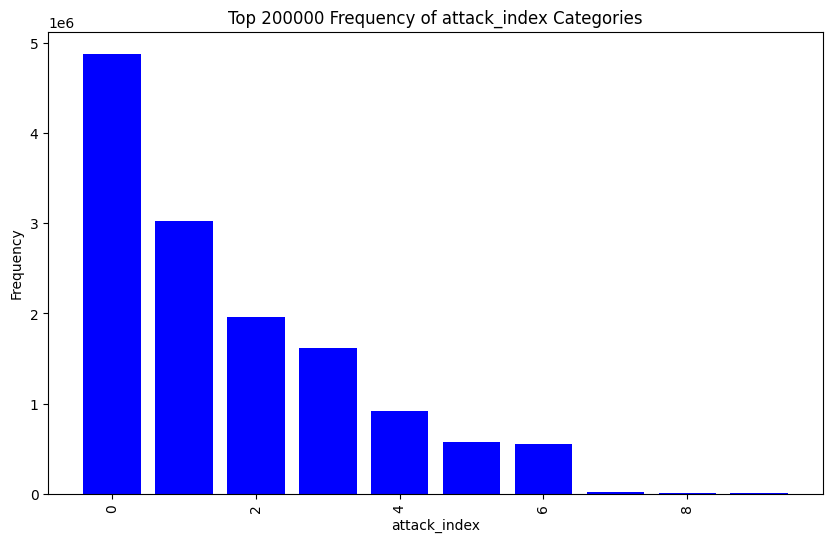

In [79]:
# Frequencias de categoria (plot)
import matplotlib.pyplot as plt
import pandas as pd

# This function plots the top categories in a given column
# It reduces the dataset to the top ROW_LIMIT categories before plotting

def plot_category_frequencies(data, column):
    data = category_frequencies(data, column).limit(ROW_LIMIT).toPandas()
    plt.figure(figsize=(10, 6))
    plt.bar(data[column], data['frequency'], color='blue')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Top {ROW_LIMIT} Frequency of {column} Categories')
    plt.xticks(rotation=90)
    plt.show()

plot_category_frequencies(encoded_train_data, "attack_index")



#### Feature Scalling
Feature scaling can play a crucial role in optimizing the performance of machine learning models, especially those sensitive to the scale of input data.
Applying feature scaling to the right variables essential for improving model accuracy and efficiency. It ensures that each feature contributes equally to the decision-making process, preventing models from misinterpreting the data due to arbitrary feature scales. This leads to better, more reliable predictions in multiclass classification tasks.

In [80]:
COMPONENTS = 3

TARGET = "attack_index" 

feature_groups = {
    "ttl": ["MIN_TTL", "MAX_TTL"],
    "tcp_flags": ["CLIENT_TCP_FLAGS", "SERVER_TCP_FLAGS", "TCP_FLAGS"],
    "flow": ["LONGEST_FLOW_PKT", "SHORTEST_FLOW_PKT"],
    "duration" : ["FLOW_DURATION_MILLISECONDS"],
    "pkt_size": ["MIN_IP_PKT_LEN", "MAX_IP_PKT_LEN"],
    "tcp_win": ["TCP_WIN_MAX_IN", "TCP_WIN_MAX_OUT"],
    "l4_dst_port": ["L4_DST_PORT"],
}

FEATURES = [f"scaled_{group_name}_features" for group_name in feature_groups.keys()]



In [81]:
from pyspark.ml.feature import FeatureHasher, OneHotEncoder

'''
    This should be the proper way to encode the features
    But we're not going to use it in this notebook since not relevant for the model
    This features could be integrated in the model to improve the accuracy
    To include them add to the following pipeline
'''

# OneHot encoding for destination subnet since higher cardinality
dst_subnet_encoder = OneHotEncoder(inputCol="dst_subnet_index", outputCol="dst_subnet_vec")

# Feature hashing for source subnet since lower cardinality
src_subnet_hasher = FeatureHasher(inputCols=["src_subnet_index"], outputCol="src_subnet_hashed", numFeatures=1024)


In [82]:
# Define feature groups
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline


# Create assemblers and scalers
assemblers_and_scalers = []

def create_assembler_and_scaler(inputCols, outputCol):
    assembler = VectorAssembler(inputCols=inputCols, outputCol=outputCol)
    scaler = StandardScaler(inputCol=outputCol, outputCol=f"scaled_{outputCol}", withStd=True, withMean=True)
    return assembler, scaler

for group_name, features in feature_groups.items():
    assembler, scaler = create_assembler_and_scaler(features, f"{group_name}_features")
    assemblers_and_scalers.append(assembler)
    assemblers_and_scalers.append(scaler)

# Create the complete pipeline
pipeline = Pipeline(stages=assemblers_and_scalers)

In [83]:
# Fit the pipeline and transform the data
pipeline_model = pipeline.fit(encoded_train_data)
processed_train_data = pipeline_model.transform(encoded_train_data)

In [84]:
processed_test_data = pipeline_model.transform(encoded_test_data)

Remove unwanted colums and keeps only FEATURES and TARGET

In [85]:
dataset_features_to_keep = FEATURES + [TARGET]
to_remove = [c for c in processed_train_data.columns if c not in dataset_features_to_keep]
# Save the processed training data removing the intermediate columns
for column in to_remove:
    processed_train_data = processed_train_data.drop(column)
    processed_test_data = processed_test_data.drop(column)
# Show the final columns in the training data
print(processed_train_data.columns)


['attack_index', 'scaled_ttl_features', 'scaled_tcp_flags_features', 'scaled_flow_features', 'scaled_duration_features', 'scaled_pkt_size_features', 'scaled_tcp_win_features', 'scaled_l4_dst_port_features']


Saving the dataset including the target value for the ml alorithm

In [86]:
# Save the dataset into parquet format
processed_train_data.write.mode("overwrite").parquet("simplified_train_data.parquet")

In [87]:
processed_test_data.write.mode("overwrite").parquet("simplified_test_data.parquet")

In [88]:
processed_train_data.printSchema()
# List the columns in the processed training data
processed_train_data.columns

root
 |-- attack_index: double (nullable = false)
 |-- scaled_ttl_features: vector (nullable = true)
 |-- scaled_tcp_flags_features: vector (nullable = true)
 |-- scaled_flow_features: vector (nullable = true)
 |-- scaled_duration_features: vector (nullable = true)
 |-- scaled_pkt_size_features: vector (nullable = true)
 |-- scaled_tcp_win_features: vector (nullable = true)
 |-- scaled_l4_dst_port_features: vector (nullable = true)



['attack_index',
 'scaled_ttl_features',
 'scaled_tcp_flags_features',
 'scaled_flow_features',
 'scaled_duration_features',
 'scaled_pkt_size_features',
 'scaled_tcp_win_features',
 'scaled_l4_dst_port_features']

In [89]:
spark.stop()